# Unit 3 Supervised Learning Capstone

This capstone project is fosused on prediction of the precense of heart disease in individuals using data obtained from traditional diagnostic tests. The data is provided by the Cleveland Clinic Database. The data was provided by [Kaggel](https://www.kaggle.com/) the HEART DISEASE webpage is at this link  [HD_Dataset](https://www.kaggle.com/ronitf/heart-disease-uci).

#### Data Overview
The original data set contained personal information and more features than is provide to the public. There were originally 76 attributes measured in the original data. The data has been scrubbed of personal identifiers and the attributes reduced to 14. Of the 14 attributes there are both catigorical and continous varibles. The target feature is binary to indicate either the precence or abcense of heart disease.

In [2]:
import pandas as pd

import mlflow
from mlflow import sklearn as mlflow_sklearn

import sklearn.datasets
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier
import catboost
import lightgbm as lgb
import xgboost

In [3]:
import numpy as np
import six
from collections import defaultdict
from scipy import sparse

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.externals.joblib import Parallel, delayed
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import make_pipeline, FeatureUnion, _fit_transform_one, _transform_one

import category_encoders as ce

In [ ]:
import matplotlib.pyplot as plt

%matplotlib inline

## Import Data
### Data Set Exploration

In [4]:
# Read in data and look at first rows
df = pd.read_csv('heart.csv')
print(df.head(3))
print('')

# General stats on data
print(df.describe())
print('')

# Target bias
print('Data bias')
target_sum = df['target'].count()
target_count = df['target'].value_counts()
percent_pos = round(target_count[0] / target_sum *100,1)
percent_neg = 100 - percent_pos
print('Total number targets is {}, individuals with heart disease present is {}% positve and {}% negitive'.
      format(target_sum,str(percent_pos), str(percent_neg) ))

# Gender bias
gender_sum = df['sex'].count()
gender_count = df['sex'].value_counts()
percent_male = round(gender_count[1] / gender_sum *100,1)
percent_female = round(100 - percent_male,1)
print('Of the {} participents, {}% are Male and {}% are Female'.
      format(gender_sum,str(percent_male), str(percent_female) ))

   age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  slope  \
0   63    1   3       145   233    1        0      150      0      2.3      0   
1   37    1   2       130   250    0        1      187      0      3.5      0   
2   41    0   1       130   204    0        0      172      0      1.4      2   

   ca  thal  target  
0   0     1       1  
1   0     2       1  
2   0     2       1  

              age         sex          cp    trestbps        chol         fbs  \
count  303.000000  303.000000  303.000000  303.000000  303.000000  303.000000   
mean    54.366337    0.683168    0.966997  131.623762  246.264026    0.148515   
std      9.082101    0.466011    1.032052   17.538143   51.830751    0.356198   
min     29.000000    0.000000    0.000000   94.000000  126.000000    0.000000   
25%     47.500000    0.000000    0.000000  120.000000  211.000000    0.000000   
50%     55.000000    1.000000    1.000000  130.000000  240.000000    0.000000   
75%     61.000000  

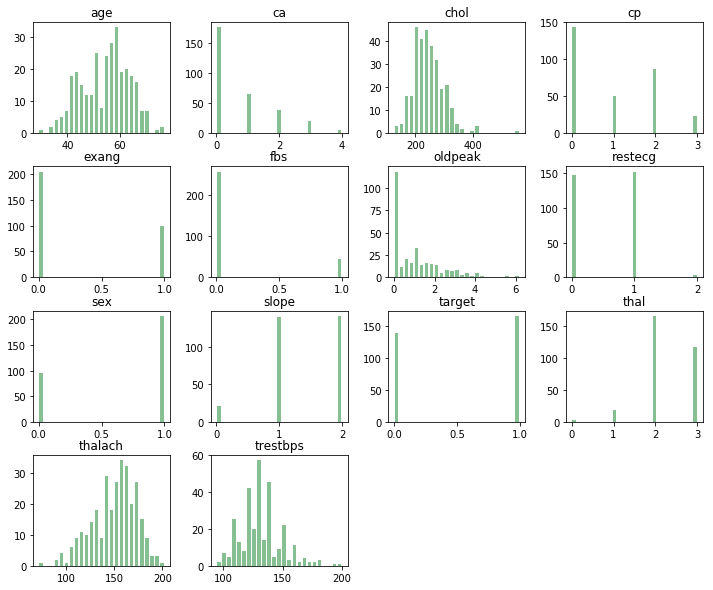

In [39]:
# Examine data for contionous or catagorical type
df.hist(bins=25, grid=False, figsize=(12,10), color='#86bf91', zorder=2, rwidth=0.7)
plt.show()

In [44]:
# Reorder columns to group varibles by type [continous, catagorical, binary]
cols = list(df.columns.values)
new_index = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak', 'cp',  'restecg', 'slope', 'ca', 'thal', 'exang', 'fbs', 'sex', 'target']
df = df.reindex(columns=new_index)
df.head(3)

,age,trestbps,chol,thalach,oldpeak,cp,restecg,slope,ca,thal,exang,fbs,sex,target
0,63,145,233,150,2.3,3,0,0,0,1,0,1,1,1
1,37,130,250,187,3.5,2,1,0,0,2,0,0,1,1
2,41,130,204,172,1.4,1,0,2,0,2,0,0,0,1


     count       mean       std   min    25%   50%   75%   max
sex                                                           
0     96.0  55.677083  9.409396  34.0  49.75  57.0  63.0  76.0
1    207.0  53.758454  8.883803  29.0  47.00  54.0  59.5  77.0


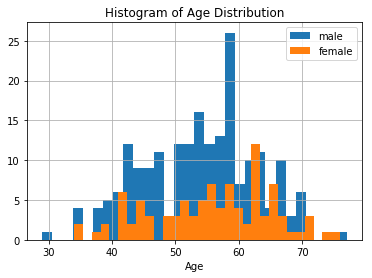

In [20]:

age_female = df.age[df['sex']==0]
age_male = df.age[df['sex']==1]
df_age = df.copy()
df_age = df_age.groupby('sex')
print(df_age['age'].describe())
# Plot Data
age_male.hist(bins=30)
age_female.hist(bins=30)
plt.title('Histogram of Age Distribution')
plt.legend(['male','female'])
plt.xlabel('Age')
plt.show()

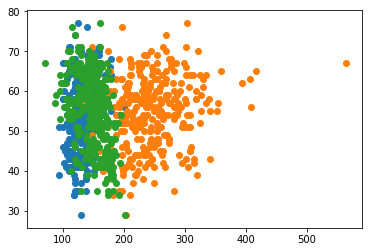

In [51]:
plt.scatter(df.trestbps,  df.age)
plt.scatter(df.chol,  df.age)
plt.scatter(df.thalach,  df.age)
plt.

In [ ]:
class PandasFeatureUnion(FeatureUnion):
    def fit_transform(self, X, y=None, **fit_params):
        self._validate_transformers()
        result = Parallel(n_jobs=self.n_jobs)(
            delayed(_fit_transform_one)(trans, X, y, weight,
                                        **fit_params)
            for name, trans, weight in self._iter())

        if not result:
            # All transformers are None
            return np.zeros((X.shape[0], 0))
        Xs, transformers = zip(*result)
        self._update_transformer_list(transformers)
        if any(sparse.issparse(f) for f in Xs):
            Xs = sparse.hstack(Xs).tocsr()
        else:
            Xs = self.merge_dataframes_by_column(Xs)
        return Xs

    def merge_dataframes_by_column(self, Xs):
        return pd.concat(Xs, axis="columns", copy=False)

    def transform(self, X):
        Xs = Parallel(n_jobs=self.n_jobs)(
            delayed(_transform_one)(trans, X, None, weight)
            for name, trans, weight in self._iter())
        if not Xs:
            # All transformers are None
            return np.zeros((X.shape[0], 0))
        if any(sparse.issparse(f) for f in Xs):
            Xs = sparse.hstack(Xs).tocsr()
        else:
            Xs = self.merge_dataframes_by_column(Xs)
        return Xs

In [ ]:
def _name_estimators(estimators):
    """Generate names for estimators."""

    names = [type(estimator).__name__.lower() for estimator in estimators]
    namecount = defaultdict(int)
    for est, name in zip(estimators, names):
        namecount[name] += 1

    for k, v in list(six.iteritems(namecount)):
        if v == 1:
            del namecount[k]

    for i in reversed(range(len(estimators))):
        name = names[i]
        if name in namecount:
            names[i] += "-%d" % namecount[name]
            namecount[name] -= 1

    return list(zip(names, estimators))

In [ ]:
def make_pandas_union(*transformers, **kwargs):
    n_jobs = kwargs.pop('n_jobs', None)
    if kwargs:
        raise TypeError('Unknown keyword arguments: "{}"'
                        .format(list(kwargs.keys())[0]))
    return PandasFeatureUnion(_name_estimators(transformers), n_jobs=n_jobs)

In [ ]:
class OrdinalEncoderPandas(TransformerMixin, BaseEstimator):
    def __init__(self, columns):
        self.columns = columns
        self.transformers = {}
    
    def fit(self, X, y=None):
        for column in self.columns:
            self.transformers[column] = ce.OrdinalEncoder(return_df=False, handle_unknown="impute").fit(X[[column]])
        return self
    
    def transform(self, X, y=None):
        X = X.drop(list(set(X.columns) - set(self.columns)), axis=1)
        for column in self.columns:
            X[column] = self.transformers[column].transform(X[[column]])
            X[column] = X[column].apply(lambda x: x if x else -1)
        return X

In [ ]:
class OneHotEncoderPandas(TransformerMixin, BaseEstimator):
    def __init__(self, columns):
        self.columns = columns
        self.transformers = {}
        self.feature_names = {}
        self.feature_names_all = []

    def fit(self, X, y=None):
        for column in self.columns:
            self.transformers[column] = OneHotEncoder(sparse=False, handle_unknown='ignore').fit(X[[column]])
            features = [f"{column}_{i}" for i in self.transformers[column].get_feature_names()]
            self.feature_names[column] = features
            for feature in features:
                self.feature_names_all.append(feature)
        return self

    def transform(self, X, y=None):
        ohe_df_list = []
        for column in self.columns:
            ohe_df = pd.DataFrame(self.transformers[column].transform(X[[column]]))
            feature_names = [f"{column}_{i}" for i in self.transformers[column].get_feature_names()]
            ohe_df.columns = self.feature_names[column]
            ohe_df_list.append(ohe_df)
        ohe_df_concat = pd.concat(ohe_df_list, axis=1)
        return ohe_df_concat

In [ ]:
class DropColumn(TransformerMixin, BaseEstimator):
    def __init__(self, columns, no_drops):
        self.columns = columns
        self.no_drops = no_drops

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        for column in self.columns:
            if column in X.columns:
                drop_together = False
                if self.no_drops:
                    for no_drop in self.no_drops:
                        if column == no_drop and self.no_drops[no_drop] not in X.columns:
                            drop_together = True
                if not drop_together:
                    X = X.drop(columns=column)
            else:
                print(f"Drop Warning: Column {column} not in X")
        return X

In [ ]:
class ChangeColumnType(TransformerMixin, BaseEstimator):
    def __init__(self, types):
        self.types = types

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        for column in self.types.keys():
            if column in X.columns:
                X[column] = X[column].astype(self.types[column])
            else:
                print(f"Change Warning: Column {column} not in X")
        return X

## Notes:
- XGBoost/Random Forest requires OHE of categorical variables unless categorial variable is ordinal
- XGBoost/LightGBM/Catboost supports missing variables, but RandomForests do not (most models in sklearn does not support missing values)

### Synthetic dataset with features 0 to 3 (4 feature in total) categorical type

In [ ]:
samples = sklearn.datasets.make_classification(n_samples=100000, scale=10, random_state=0)

In [ ]:
feature_names = [f"feature_{i}" for i in range(samples[0].shape[1])]
target = "target"

In [ ]:
df_samples = pd.concat([pd.DataFrame(samples[0], columns=feature_names), pd.DataFrame(samples[1], columns=[target])], axis=1)

In [ ]:
categorical_features = list(df_samples.columns[0:4])

In [ ]:
for i in categorical_features:
    df_samples[i] = abs(df_samples[i]).astype(int).astype(str)

In [ ]:
df_samples.head()

In [ ]:
df_samples[target].value_counts()

### Pipeline for Models that does not support categorical variables

Need to use OHE, only when you know the data is not ordinal, otherwise you can use ordinal encoding

XGBoost, RandomForest (CART can handle categorical, but RF does not have this implemented)

In [ ]:
pipe_ohe = make_pipeline(
    make_pandas_union(
        DropColumn(columns=categorical_features, no_drops=None),
        make_pipeline(
            ChangeColumnType(types={i: str for i in categorical_features}),
            OneHotEncoderPandas(columns=categorical_features)
        )
    )
)

In [ ]:
pipe_ohe.fit_transform(df_samples).head(5)

In [ ]:
ohe_columns = list(set(pipe_ohe.fit_transform(df_samples).columns) - set([target]))

### Pipeline for models that support categorical variables

LightGBM, CatBoost can handle categorical variables

In [ ]:
pipe_cat = make_pipeline(
    make_pandas_union(
        DropColumn(columns=categorical_features, no_drops=None),
        OrdinalEncoderPandas(columns=categorical_features)
    ),
    ChangeColumnType(types={i: "category" for i in categorical_features}),
)

In [ ]:
pipe_cat.fit_transform(df_samples).head(5)

## Training/Testing/Validation

In [ ]:
df_samples_ohe = pipe_ohe.fit_transform(df_samples)
train_ohe, test_ohe = train_test_split(df_samples_ohe, test_size=0.2, stratify=df_samples_ohe[target], random_state=0)
train_ohe, valid_ohe = train_test_split(train_ohe, test_size=0.2, stratify=train_ohe[target], random_state=0)

In [ ]:
df_samples_cat = pipe_cat.fit_transform(df_samples)
train_cat, test_cat = train_test_split(df_samples_cat, test_size=0.2, stratify=df_samples_cat[target], random_state=0)
train_cat, valid_cat = train_test_split(train_cat, test_size=0.2, stratify=train_cat[target], random_state=0)

### Without ML-Flow

In [ ]:
rf_classifier = RandomForestClassifier(
    criterion='entropy',
    max_features=None,
    n_estimators=20,
    max_depth=4,
    random_state=0,
    n_jobs=4)

In [ ]:
rf_classifier.fit(X=train_ohe[ohe_columns], y=train_ohe[target])
# Use validation set to modify hyperparameters
print(accuracy_score(valid_ohe[target], rf_classifier.predict(valid_ohe[ohe_columns])))
# Use testing set to evaluate final performance
print(accuracy_score(test_ohe[target], rf_classifier.predict(test_ohe[ohe_columns])))

In [ ]:
xgb_classifier = xgboost.XGBClassifier(
    max_depth=4,
    learning_rate=0.008,
    n_estimators=200
)

In [ ]:
xgb_classifier.fit(X=train_ohe[ohe_columns], y=train_ohe[target])
# Use validation set to modify hyperparameters
print(accuracy_score(valid_ohe[target], xgb_classifier.predict(valid_ohe[ohe_columns])))
# Use testing set to evaluate final performance
print(accuracy_score(test_ohe[target], xgb_classifier.predict(test_ohe[ohe_columns])))

In [ ]:
lgb_classifier = lightgbm.LGBMClassifier(
    objective="binary",
    categorical_features="auto",
    max_depth=4,
    learning_rate=0.01,
    n_estimators=200
)

In [ ]:
lgb_classifier.fit(X=train_ohe[ohe_columns], y=train_ohe[target])
# Use validation set to modify hyperparameters
print(accuracy_score(valid_ohe[target], lgb_classifier.predict(valid_ohe[ohe_columns])))
# Use testing set to evaluate final performance
print(accuracy_score(test_ohe[target], lgb_classifier.predict(test_ohe[ohe_columns])))

In [ ]:
cat_classifier = catboost.CatBoostClassifier(
    max_depth=4,
    learning_rate=0.01,
    n_estimators=200,
    verbose=0
)

In [ ]:
cat_classifier.fit(X=train_ohe[ohe_columns], y=train_ohe[target])
# Use validation set to modify hyperparameters
print(accuracy_score(valid_ohe[target], cat_classifier.predict(valid_ohe[ohe_columns])))
# Use testing set to evaluate final performance
print(accuracy_score(test_ohe[target], cat_classifier.predict(test_ohe[ohe_columns])))

### With ML-Flow

In [ ]:
mlflow.set_experiment("Training/Testing/Validation")

In [ ]:
with mlflow.start_run(run_name="Random Forest"):
    criterion = "entropy"
    max_features = None
    n_estimators = 20
    max_depth = 4
    
    rf_classifier = RandomForestClassifier(
        criterion=criterion,
        max_features=max_features,
        n_estimators=n_estimators,
        max_depth=max_depth,
        random_state=0,
        n_jobs=4)
    rf_classifier.fit(X=train_ohe[ohe_columns], y=train_ohe[target])
    
    valid_accuracy = accuracy_score(valid_ohe[target], rf_classifier.predict(valid_ohe[ohe_columns]))
    test_accuracy = accuracy_score(test_ohe[target], rf_classifier.predict(test_ohe[ohe_columns]))
    
    mlflow.log_param("criterion", criterion)
    mlflow.log_param("max_features", max_features)
    mlflow.log_param("n_estimators", n_estimators)
    mlflow.log_param("max_depth", max_depth)
    
    mlflow.log_metric("valid_accuracy", valid_accuracy)
    mlflow.log_metric("test_accuracy", test_accuracy)

    mlflow_sklearn.log_model(rf_classifier, "model")

In [ ]:
with mlflow.start_run(run_name="XGBoost"):
    n_estimators = 200
    max_depth = 4
    learning_rate = 0.008
    
    xgb_classifier = xgboost.XGBClassifier(
        max_depth=max_depth,
        learning_rate=learning_rate,
        n_estimators=n_estimators
    )
    xgb_classifier.fit(X=train_ohe[ohe_columns], y=train_ohe[target])
    
    valid_accuracy = accuracy_score(valid_ohe[target], xgb_classifier.predict(valid_ohe[ohe_columns]))
    test_accuracy = accuracy_score(test_ohe[target], xgb_classifier.predict(test_ohe[ohe_columns]))
    
    mlflow.log_param("criterion", criterion)
    mlflow.log_param("max_features", max_features)
    mlflow.log_param("n_estimators", n_estimators)
    mlflow.log_param("max_depth", max_depth)
    
    mlflow.log_metric("valid_accuracy", valid_accuracy)
    mlflow.log_metric("test_accuracy", test_accuracy)

    mlflow_sklearn.log_model(xgb_classifier, "model")

In [ ]:
with mlflow.start_run(run_name="LightGBM"):
    objective = "binary"
    categorical_features = "auto"
    n_estimators = 200
    max_depth = 4
    learning_rate = 0.01
    
    lgb_classifier = lightgbm.LGBMClassifier(
        objective=objective,
        categorical_features=categorical_features,
        max_depth=max_depth,
        learning_rate=learning_rate,
        n_estimators=n_estimators
    )
    lgb_classifier.fit(X=train_ohe[ohe_columns], y=train_ohe[target])
    
    valid_accuracy = accuracy_score(valid_ohe[target], lgb_classifier.predict(valid_ohe[ohe_columns]))
    test_accuracy = accuracy_score(test_ohe[target], lgb_classifier.predict(test_ohe[ohe_columns]))
    
    mlflow.log_param("criterion", criterion)
    mlflow.log_param("max_features", max_features)
    mlflow.log_param("n_estimators", n_estimators)
    mlflow.log_param("max_depth", max_depth)
    
    mlflow.log_metric("valid_accuracy", valid_accuracy)
    mlflow.log_metric("test_accuracy", test_accuracy)

    mlflow_sklearn.log_model(lgb_classifier, "model")

In [ ]:
with mlflow.start_run(run_name="CatBoost"):
    n_estimators = 200
    max_depth = 4
    learning_rate = 0.01
    
    cat_classifier = catboost.CatBoostClassifier(
        max_depth=max_depth,
        learning_rate=learning_rate,
        n_estimators=n_estimators,
        verbose=0
    )
    cat_classifier.fit(X=train_ohe[ohe_columns], y=train_ohe[target])
    
    valid_accuracy = accuracy_score(valid_ohe[target], cat_classifier.predict(valid_ohe[ohe_columns]))
    test_accuracy = accuracy_score(test_ohe[target], cat_classifier.predict(test_ohe[ohe_columns]))
    
    mlflow.log_param("criterion", criterion)
    mlflow.log_param("max_features", max_features)
    mlflow.log_param("n_estimators", n_estimators)
    mlflow.log_param("max_depth", max_depth)
    
    mlflow.log_metric("valid_accuracy", valid_accuracy)
    mlflow.log_metric("test_accuracy", test_accuracy)

    mlflow_sklearn.log_model(cat_classifier, "model")

In [ ]:
!mlflow ui --host 0.0.0.0

## Training/Testing/Validation with Early Stopping

### Without ML-Flow

### With ML-Flow

## Training/Testing with CV

### Without ML-Flow

### With ML-Flow

## Training/Testing with CV with Early Stopping

### Without ML-Flow

### With ML-Flow

## Nested CV

### Without ML-Flow

### With ML-Flow

## Nested CV with Early Stopping

### Without ML-Flow

### With ML-Flow